In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
# list of all the libraries that will be used:

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# map rendering library
!conda install -c conda-forge folium=0.5.0 --yes
import folium 

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  51.64 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.10 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  38.07 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  48.28 MB/s
Libraries imported.


# 1. Geographical Coordinates of the Neighborhoods of San Diego

Wikipedia lists all the neighborhoods of San Diego: https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego

Web scraping --> I will use the "Beautiful Soup" python library to get the data from the table.

## 1.1 Extract the list of neighborhoods of San Diego from a Wikipedia

In [3]:
url   = 'https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego'
website_url = requests.get(url).text

# Prettify() function in BeautifulSoup will enable us to view how the tags are nested in the document
soup = BeautifulSoup(website_url,'lxml')

In [4]:
# extract the table
mytable  = soup.find('table')

# find all the rows that have an href to something
all_href = mytable.find_all('a',href=True)
# transform into an array of strings
all_text = np.array([str(aa) for aa in all_href])

# find the part that has the image (I need to remove this from the all_href)
image    = mytable.find_all('a',{'class':'image'},href=True)
img_text = [str(tt) for tt in image]

# find at which index the image text is in all_href
idx      = np.where(all_text == img_text)

# delete the image text from the all_text
all_text = np.delete(all_text,idx,0)
all_text

array([ '<a class="mw-redirect" href="/wiki/Balboa_Park,_San_Diego" title="Balboa Park, San Diego">Balboa Park</a>',
       '<a href="/wiki/Bankers_Hill,_San_Diego" title="Bankers Hill, San Diego">Bankers Hill</a>',
       '<a href="/wiki/Barrio_Logan,_San_Diego" title="Barrio Logan, San Diego">Barrio Logan</a>',
       '<a class="mw-redirect" href="/wiki/Bay_Ho,_San_Diego" title="Bay Ho, San Diego">Bay Ho</a>',
       '<a class="mw-redirect" href="/wiki/Bay_Park,_San_Diego" title="Bay Park, San Diego">Bay Park</a>',
       '<a href="/wiki/Birdland,_San_Diego" title="Birdland, San Diego">Birdland</a>',
       '<a href="/wiki/Black_Mountain_Ranch,_San_Diego" title="Black Mountain Ranch, San Diego">Black Mountain Ranch</a>',
       '<a class="mw-redirect" href="/wiki/Border,_San_Diego" title="Border, San Diego">Border</a>',
       '<a href="/wiki/Burlingame,_San_Diego" title="Burlingame, San Diego">Burlingame</a>',
       '<a href="/wiki/Carmel_Mountain_Ranch,_San_Diego" title="Carmel Mo

From the soup, I can get all the href lines, and select only those with "../zip-code/california/san_diego/" in it. From those, I can split each row, and get only the postal code.

In [5]:
neighs = []
for aa in all_text:
    if 'title' in aa:
        try:
            neighs.append(aa.split('title')[1].split('>')[1].split('<')[0])
        except:
            print("no suburb here")
        
"""
# post codes from this website:
url = 'https://www.bestplaces.net/find/zip.aspx?st=ca&city=0666000'
tmp = soup.find_all('a', href=True)
post_codes = []
for tt in tmp:
    if "../zip-code/california/san_diego/" in str(tt):
        post_codes.append(str(tt).split('<u>')[1].split()[0])"""

no suburb here
no suburb here
no suburb here
no suburb here
no suburb here


'\n# post codes from this website:\nurl = \'https://www.bestplaces.net/find/zip.aspx?st=ca&city=0666000\'\ntmp = soup.find_all(\'a\', href=True)\npost_codes = []\nfor tt in tmp:\n    if "../zip-code/california/san_diego/" in str(tt):\n        post_codes.append(str(tt).split(\'<u>\')[1].split()[0])'

In [6]:
print("There are %i neighborhoods in San Diego" %len(neighs))

There are 122 neighborhoods in San Diego


Now I can use the list that I just found to create a dataframe.

In [7]:
# create a dataframe with PostalCode, Borough, and Neighborhood using the lists found above
df = pd.DataFrame()
df['Neighborhood'] = neighs
df["Latitude"]     = np.nan
df["Longitude"]    = np.nan
df.head()

,Neighborhood,Latitude,Longitude
0,Balboa Park,NaN,NaN
1,Bankers Hill,NaN,NaN
2,Barrio Logan,NaN,NaN
3,Bay Ho,NaN,NaN
4,Bay Park,NaN,NaN


I need to clean the table, because there are rows with missing neighborhoods and the first row has a neighborhood called "neighborhoods"... very unlikely...

In [8]:
# drop empty Neighborhoods rows and the row that contains "Neighborhood"
to_drop = ['San Diego', 'neighborhoods','Neighborhood','']
for tt in to_drop:
    df = df[df['Neighborhood']!=tt]
df.reset_index(drop=True,inplace=True)
df.head()

,Neighborhood,Latitude,Longitude
0,Balboa Park,NaN,NaN
1,Bankers Hill,NaN,NaN
2,Barrio Logan,NaN,NaN
3,Bay Ho,NaN,NaN
4,Bay Park,NaN,NaN


So, now the dataframe has the following shape:

In [9]:
df.shape

(121, 3)

## 1.2 Get the coordinates of the neighborhoods using the libaray _geopy.geocoders.Nominatim_

In [10]:
geolocator  = Nominatim(user_agent="ny_explorer")
for neigh in df['Neighborhood']:
    try:
        address   = '%s, San Diego, California ' %(neigh)
        location  = geolocator.geocode(address)
        latitude  = location.latitude
        longitude = location.longitude
        #print('The geographical coordinates of {}, San Diego California are {}, {}.'.format(neigh,latitude, longitude))
        df.loc[df['Neighborhood']==neigh, 'Latitude']  = latitude
        df.loc[df['Neighborhood']==neigh, 'Longitude'] = longitude
    except:
        print('%s is not a neighborhood in the library... Hence, I cannot get the coordinates, and I will drop it from the dataframe' %neigh)
        df = df[df['Neighborhood']!=neigh]

df.reset_index(drop=True,inplace=True)        

College Area is not a neighborhood in the library... Hence, I cannot get the coordinates, and I will drop it from the dataframe
Downtown San Diego (Centre City) is not a neighborhood in the library... Hence, I cannot get the coordinates, and I will drop it from the dataframe
East Elliott is not a neighborhood in the library... Hence, I cannot get the coordinates, and I will drop it from the dataframe
Egger Highlands is not a neighborhood in the library... Hence, I cannot get the coordinates, and I will drop it from the dataframe
Marston Hills is not a neighborhood in the library... Hence, I cannot get the coordinates, and I will drop it from the dataframe
Ocean Crest is not a neighborhood in the library... Hence, I cannot get the coordinates, and I will drop it from the dataframe
Ocean View Hills is not a neighborhood in the library... Hence, I cannot get the coordinates, and I will drop it from the dataframe
Point Loma Heights is not a neighborhood in the library... Hence, I cannot ge

There was still some rubbish, and getting the coordinates allowed to further clean the dataset

In [11]:
df.head()

,Neighborhood,Latitude,Longitude
0,Balboa Park,32.731357,-117.146527
1,Bankers Hill,32.728293,-117.162105
2,Barrio Logan,32.693886,-117.138007
3,Bay Ho,32.879353,-117.231100
4,Bay Park,32.784638,-117.202605


Now the size of the dataframe is:

In [12]:
df.shape

(111, 3)

## 2. Create a map of the Neighborhoods of San Diego

In [13]:
# create map of San Diego:
address     = 'San Diego, California'
location    = geolocator.geocode(address)
latitudeSD  = location.latitude
longitudeSD = location.longitude
map_SD      = folium.Map(location=[latitudeSD, longitudeSD], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'],df['Longitude'],df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SD)  
    
map_SD

## !!! THE MAP DOES NOT SHOW ON GITHUB.. To visualize the whole notebook with the folium map, Please, copy the link of this notebook and paste it on https://nbviewer.jupyter.org/ !!! Thank you!!

## 3. Explore the neighborhoods using the _Foursquare API_

In [14]:
# The code was removed by Watson Studio for sharing.

### 3.1 Extract 100 venues that are in each neighborhood, within a radius of 500 m 

In [41]:
# create a function that will take the name of the neighborhood and its lat and lon, 
# and will return the venues in a radius of 500 m
def getNearbyVenues(cat, names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        print(name)
        # create the API request URL
        if cat is None:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        else:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, cat, radius, LIMIT)
        try:    
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                                name, 
                                lat, 
                                lng, 
                                v['venue']['name'], 
                                v['venue']['location']['lat'], 
                                v['venue']['location']['lng'],  
                                v['venue']['categories'][0]['name']) for v in results])
        except:
            print(lat,lng,name)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    return(nearby_venues)

In [16]:
# run the function to get 100 venues in the previously selected Boroughs
LIMIT  = 100
neighs_venues = getNearbyVenues(None,
                                names      = df['Neighborhood'],
                                latitudes  = df['Latitude'],
                                longitudes = df['Longitude'],
                                radius     = 500
                               )


Balboa Park
Bankers Hill
Barrio Logan
Bay Ho
Bay Park
Birdland
Black Mountain Ranch
Border
Burlingame
Carmel Mountain Ranch
Carmel Valley
City Heights
Clairemont
Del Mar Heights
Del Mar Mesa
Columbia
Core
Cortez Hill
East Village
Gaslamp Quarter
Little Italy
Marina
El Cerrito
Gateway
Golden Hill
Grant Hill
Harbor Island
Harborview
Hillcrest
Kearny Mesa
Kensington
La Jolla
La Jolla Village
Torrey Pines
Village of La Jolla
Linda Vista
Logan Heights
Memorial
Midtown
Mira Mesa
Miramar
Mission Beach
Mission Hills
Mission Valley
Civita
Morena
Navajo
Allied Gardens
Del Cerro
Grantville
San Carlos
Nestor
Normal Heights
North City
North Park
North Clairemont
Oak Park
Ocean Beach
Old Town
Otay Mesa
Otay Mesa West
Pacific Beach
Pacific Highlands Ranch
Palm City
Point Loma
La Playa
Loma Portal
Midway
Roseville-Fleetridge
Sunset Cliffs
Wooded Area
Rancho Bernardo
Rancho Encantada
Rancho Peñasquitos
Rolando
Rolando Park
Sabre Springs
San Pasqual Valley
San Ysidro
Scripps Ranch
Serra Mesa
Shelter Isl

In [21]:
neighs_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balboa Park,32.731357,-117.146527,San Diego Natural History Museum,32.732239,-117.147395,History Museum
1,Balboa Park,32.731357,-117.146527,San Diego Model Railroad Museum,32.731132,-117.148365,Museum
2,Balboa Park,32.731357,-117.146527,Balboa Park Fountain,32.731453,-117.146809,Fountain
3,Balboa Park,32.731357,-117.146527,Botanical Building & Lily Pond,32.732237,-117.149288,Botanical Garden
4,Balboa Park,32.731357,-117.146527,Spanish Village Art Center,32.733498,-117.147610,Arts & Crafts Store


In [17]:
# size of the venues
print(neighs_venues.shape)

(2687, 7)


### 3.2 Extract the popular neighborhoods

In [18]:
# count by neighborhood:
#borough_venues['Neighborhood'] = borough_venues['Neighborhood'].apply(tuple)
df2 = neighs_venues.groupby('Neighborhood')['Neighborhood','Venue'].count()
df2.rename(columns={'Neighborhood': 'count'},inplace=True)
df2.reset_index(level=0, inplace=True)

# let's use only those neighborhoods that have at least 20 venues (i.e. likely there are more people visiting them)
popular_df = neighs_venues[neighs_venues['Neighborhood'].isin(df2.loc[df2['count']>=20,'Neighborhood'])]
popular_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balboa Park,32.731357,-117.146527,San Diego Natural History Museum,32.732239,-117.147395,History Museum
1,Balboa Park,32.731357,-117.146527,San Diego Model Railroad Museum,32.731132,-117.148365,Museum
2,Balboa Park,32.731357,-117.146527,Balboa Park Fountain,32.731453,-117.146809,Fountain
3,Balboa Park,32.731357,-117.146527,Botanical Building & Lily Pond,32.732237,-117.149288,Botanical Garden
4,Balboa Park,32.731357,-117.146527,Spanish Village Art Center,32.733498,-117.147610,Arts & Crafts Store


In [19]:
print('There are a total of {} neighborhoods, with {} uniques categories.'.format(len(popular_df['Neighborhood'].unique()),len(popular_df['Venue Category'].unique())))

There are a total of 42 neighborhoods, with 263 uniques categories.


### 3.3 Analyze each popular neighborhood

In [20]:
# one hot encoding (since I want to use the k-mean clustering algorithm, I have to transform my categorical data into numerical)
neigh_onehot   = pd.get_dummies(popular_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neigh_onehot['Neighborhood'] = popular_df['Neighborhood'] 
# find where which column is 'Neighborhood'
locNeigh       = neigh_onehot.columns.get_loc('Neighborhood')
# move neighborhood column to the first column
fixed_columns  = [neigh_onehot.columns[locNeigh]] + list(neigh_onehot.columns[:locNeigh]) + list(neigh_onehot.columns[locNeigh+1:])
neigh_onehot   = neigh_onehot[fixed_columns]

In [21]:
# size of the new dataframe
neigh_onehot.shape

(2169, 263)

In [22]:
neigh_onehot.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [23]:
SD_grouped = neigh_onehot.groupby('Neighborhood').mean().reset_index()
SD_grouped.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Balboa Park,0.000000,0.000000,0.019231,0.019231,0.0,0.0,0.0,0.000000,0.096154,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.096154
1,Bankers Hill,0.000000,0.000000,0.058824,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,Barrio Logan,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.047619,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,Bay Ho,0.000000,0.000000,0.041667,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,Border,0.018519,0.055556,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.018519,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.000000


In [24]:
SD_grouped.shape

(42, 263)

Let's print each neighborhood along with the top 10 most common venues

In [27]:
num_top_venues = 10

for hood in SD_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = SD_grouped[SD_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Balboa Park----
                          venue  freq
0                   Zoo Exhibit  0.10
1                    Art Museum  0.10
2                        Garden  0.10
3                       Theater  0.06
4                          Café  0.04
5         Performing Arts Venue  0.04
6                History Museum  0.04
7  Theme Park Ride / Attraction  0.04
8                     Gift Shop  0.04
9                       Exhibit  0.04


----Bankers Hill----
                 venue  freq
0                  Spa  0.12
1  American Restaurant  0.06
2          Coffee Shop  0.06
3     Ramen Restaurant  0.03
4           Taco Place  0.03
5     Sculpture Garden  0.03
6                Motel  0.03
7                 Food  0.03
8                 Park  0.03
9       Breakfast Spot  0.03


----Barrio Logan----
                  venue  freq
0  Fast Food Restaurant  0.19
1           Coffee Shop  0.10
2    Mexican Restaurant  0.10
3            Taco Place  0.10
4         Jewelry Store  0.05
5           Tailo

Save what we just found in a dataframe

In [28]:
# first, sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
# then, create the dataframe
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = SD_grouped['Neighborhood']

for ind in np.arange(SD_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SD_grouped.iloc[ind, :], num_top_venues)

# drop the Neighborhood column, since we will just need numbers for the model
SD_grouped_clustering = SD_grouped.drop('Neighborhood', 1)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balboa Park,Zoo Exhibit,Garden,Art Museum,Theater,History Museum,Performing Arts Venue,Gift Shop,Café,Exhibit,Theme Park Ride / Attraction
1,Bankers Hill,Spa,American Restaurant,Coffee Shop,Restaurant,Sports Club,Gastropub,Liquor Store,Lounge,Taco Place,Sushi Restaurant
2,Barrio Logan,Fast Food Restaurant,Coffee Shop,Mexican Restaurant,Taco Place,Convenience Store,Shopping Mall,Boat or Ferry,Gift Shop,Tailor Shop,Art Gallery
3,Bay Ho,Bus Stop,Gym Pool,Sandwich Place,Seafood Restaurant,Market,Salad Place,Farmers Market,Baseball Stadium,Greek Restaurant,Coffee Shop
4,Border,Clothing Store,Shoe Store,Men's Store,Accessories Store,Women's Store,Outlet Store,Sandwich Place,Food Court,Snack Place,Shopping Mall


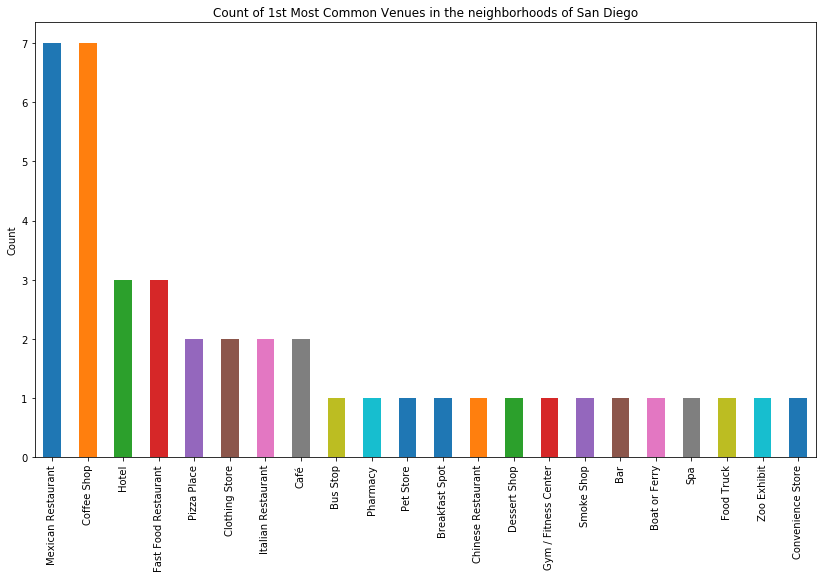

In [30]:
#neighborhoods_venues_sorted.hist(neighborhoods_venues_sorted['1st Most Common Venue'])
name_ind_map = {x:y for x, y in zip(neighborhoods_venues_sorted["Neighborhood"],neighborhoods_venues_sorted["1st Most Common Venue"])}
ax = neighborhoods_venues_sorted['1st Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Count of 1st Most Common Venues in the neighborhoods of San Diego")
#ax.set_xlabel("")
ax.set_ylabel("Count")
plt.show()

In [125]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['1st Most Common Venue']=='Coffee Shop']

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Cortez Hill,Coffee Shop,Pizza Place,Café,Mexican Restaurant,Taco Place,Park,Hotel,Donut Shop,Bus Stop,Business Service
17,Golden Hill,Coffee Shop,Pizza Place,Mexican Restaurant,Bakery,Steakhouse,Taco Place,Mediterranean Restaurant,Sandwich Place,Market,Eastern European Restaurant
29,Mission Valley,Coffee Shop,Burger Joint,Pizza Place,Furniture / Home Store,Cosmetics Shop,Mexican Restaurant,Salon / Barbershop,Jewelry Store,Department Store,Bookstore
32,North Park,Coffee Shop,Mexican Restaurant,Pizza Place,Brewery,Sushi Restaurant,Bar,American Restaurant,Breakfast Spot,Ice Cream Shop,Beer Bar
33,Ocean Beach,Coffee Shop,Mexican Restaurant,Brewery,Bar,Italian Restaurant,Breakfast Spot,Café,Sushi Restaurant,Antique Shop,ATM
40,Sorrento Mesa,Coffee Shop,Pizza Place,Sandwich Place,Mexican Restaurant,Italian Restaurant,Frozen Yogurt Shop,Thrift / Vintage Store,Bank,Chinese Restaurant,Cosmetics Shop
42,University City,Coffee Shop,Clothing Store,Burger Joint,Ice Cream Shop,Cosmetics Shop,Mexican Restaurant,Shoe Store,Optical Shop,Shopping Mall,Frozen Yogurt Shop
44,Village of La Jolla,Coffee Shop,Italian Restaurant,Café,Juice Bar,Gym,Breakfast Spot,Sandwich Place,Sporting Goods Shop,Pub,Ice Cream Shop


### 3.4 Investigate the data

Let's count the number of nightlife spots and restaruants in the areas. The codes of the categories were taken from Foursquare.

In [31]:
#night_category        = '4d4b7105d754a06376d81259'
cocktail_bar_category = '4bf58dd8d48988d11e941735'
food_category         = '4d4b7105d754a06374d81259'

In [42]:
cocktail_bars = getNearbyVenues(cocktail_bar_category,names      = df['Neighborhood'],
                                 latitudes  = df['Latitude'],
                                 longitudes = df['Longitude'],
                                 radius     = 500
                               )

Balboa Park
Bankers Hill
Barrio Logan
Bay Ho
Bay Park
Birdland
Black Mountain Ranch
Border
Burlingame
Carmel Mountain Ranch
Carmel Valley
City Heights
Clairemont
Del Mar Heights
Del Mar Mesa
Columbia
Core
Cortez Hill
East Village
Gaslamp Quarter
Little Italy
Marina
El Cerrito
Gateway
Golden Hill
Grant Hill
Harbor Island
Harborview
Hillcrest
Kearny Mesa
Kensington
La Jolla
La Jolla Village
Torrey Pines
Village of La Jolla
Linda Vista
Logan Heights
Memorial
Midtown
Mira Mesa
Miramar
Mission Beach
Mission Hills
Mission Valley
Civita
Morena
Navajo
Allied Gardens
Del Cerro
Grantville
San Carlos
Nestor
Normal Heights
North City
North Park
North Clairemont
Oak Park
Ocean Beach
Old Town
Otay Mesa
Otay Mesa West
Pacific Beach
Pacific Highlands Ranch
Palm City
Point Loma
La Playa
Loma Portal
Midway
Roseville-Fleetridge
Sunset Cliffs
Wooded Area
Rancho Bernardo
Rancho Encantada
Rancho Peñasquitos
Rolando
Rolando Park
Sabre Springs
San Pasqual Valley
San Ysidro
Scripps Ranch
Serra Mesa
Shelter Isl

In [45]:
cocktail_bars.to_pickle('./cocktail_bars.pkl')   

In [43]:
cocktail_bars.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balboa Park,32.731357,-117.146527,Panama 66,32.731770,-117.151081,Gastropub
1,Balboa Park,32.731357,-117.146527,The Prado at Balboa Park,32.731042,-117.149792,American Restaurant
2,Bankers Hill,32.728293,-117.162105,Bankers Hill Bar & Restaurant,32.728456,-117.161419,American Restaurant
3,Bankers Hill,32.728293,-117.162105,The Balboa Bar & Grill,32.724873,-117.160062,Bar
4,Bankers Hill,32.728293,-117.162105,CUCINA urbana,32.731278,-117.160189,Italian Restaurant


In [72]:
restaurants = getNearbyVenues(food_category,names      = df['Neighborhood'],
                                 latitudes  = df['Latitude'],
                                 longitudes = df['Longitude'],
                                 radius     = 500
                               )

Balboa Park
Bankers Hill
Barrio Logan
Bay Ho
Bay Park
Birdland
Black Mountain Ranch
Border
Burlingame
Carmel Mountain Ranch
Carmel Valley
City Heights
Clairemont
Del Mar Heights
Del Mar Mesa
Columbia
Core
Cortez Hill
East Village
Gaslamp Quarter
Little Italy
Marina
El Cerrito
Gateway
Golden Hill
Grant Hill
Harbor Island
Harborview
Hillcrest
Kearny Mesa
Kensington
La Jolla
La Jolla Village
Torrey Pines
Village of La Jolla
Linda Vista
Logan Heights
Memorial
Midtown
Mira Mesa
Miramar
Mission Beach
Mission Hills
Mission Valley
Civita
Morena
Navajo
Allied Gardens
Del Cerro
Grantville
San Carlos
Nestor
Normal Heights
North City
North Park
North Clairemont
Oak Park
Ocean Beach
Old Town
Otay Mesa
Otay Mesa West
Pacific Beach
Pacific Highlands Ranch
Palm City
Point Loma
La Playa
Loma Portal
Midway
Roseville-Fleetridge
Sunset Cliffs
Wooded Area
Rancho Bernardo
Rancho Encantada
Rancho Peñasquitos
Rolando
Rolando Park
Sabre Springs
San Pasqual Valley
San Ysidro
Scripps Ranch
Serra Mesa
Shelter Isl

In [73]:
restaurants.to_pickle('./restaurants.pkl')   

In [74]:
# remove all the venues "restaurants" that are not in the list "restaurant_words"       
# extract a dataframe wiht only those venues:
restaurant_words = ['restaurant', 'diner', 'taverna', 'pub', 'café', 'steakhouse']
for venue in restaurants['Venue Category']:
    res           = False
    category_name = venue.lower()
    for r in restaurant_words:
        if r in category_name:
            res = True
            break
    if not res:
        restaurants.drop(restaurants[restaurants['Venue Category']==venue].index, inplace=True)

restaurants.reset_index(drop=True,inplace=True)
restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balboa Park,32.731357,-117.146527,The Prado at Balboa Park,32.731042,-117.149792,American Restaurant
1,Balboa Park,32.731357,-117.146527,Panama 66,32.731770,-117.151081,Gastropub
3,Balboa Park,32.731357,-117.146527,Jungle Java,32.734825,-117.149784,Café
7,Balboa Park,32.731357,-117.146527,Craveology,32.731053,-117.146950,Café
8,Balboa Park,32.731357,-117.146527,Galileo's Cafe,32.731042,-117.147163,Café


In [78]:
restaurants.groupby('Venue Category')['Venue Category'].count()

Venue Category
American Restaurant                 71
Argentinian Restaurant               5
Asian Restaurant                    22
Brazilian Restaurant                 7
Café                               115
Cajun / Creole Restaurant            1
Caribbean Restaurant                 2
Chinese Restaurant                  53
Comfort Food Restaurant              3
Dim Sum Restaurant                   1
Diner                               12
Dumpling Restaurant                  1
Eastern European Restaurant          3
Ethiopian Restaurant                 1
Falafel Restaurant                   5
Fast Food Restaurant                55
Fondue Restaurant                    4
French Restaurant                   14
Gastropub                           24
Greek Restaurant                    16
Hawaiian Restaurant                  2
Indian Chinese Restaurant            1
Indian Restaurant                   24
Irish Pub                            2
Italian Restaurant                 113
Japanese R

In [84]:
print('Average number of cocktail bars in neighborhood:', np.array([len(r) for r in cocktail_bars]).mean())
count_cocktail_bars = cocktail_bars.groupby('Neighborhood')['Neighborhood','Venue'].count()
count_cocktail_bars.rename(columns={'Neighborhood': 'Count'},inplace=True)
count_cocktail_bars.sort_values(by=['Count'],ascending=False,inplace=True)
#count_cocktail_bars['Neighborhood Longitude'] = df[df['Neighborhood'] == count_cocktail_bars['Neighborhood']]['Longitude']
#count_cocktail_bars['Neighborhood Latitude']  = df[df['Neighborhood'] == count_cocktail_bars['Neighborhood']]['Latitude']
count_cocktail_bars.reset_index(level=0, inplace=True)
count_cocktail_bars.head()

Average number of cocktail bars in neighborhood: 14.7142857143


,Neighborhood,Count,Venue
0,Gaslamp Quarter,60,60
1,Core,23,23
2,El Cerrito,18,18
3,Midway,18,18
4,Little Italy,14,14


Let's remove the Gaslamp Quarter, from the analysis: there are 60 venues considered as _cocktail bars_ in 500 m radius, which would make the competition way hard for a new bar. Also, Gaslamp Quarter is a very touristic area, as the bar plot below indicates (look at the number of hotels and restaurants):

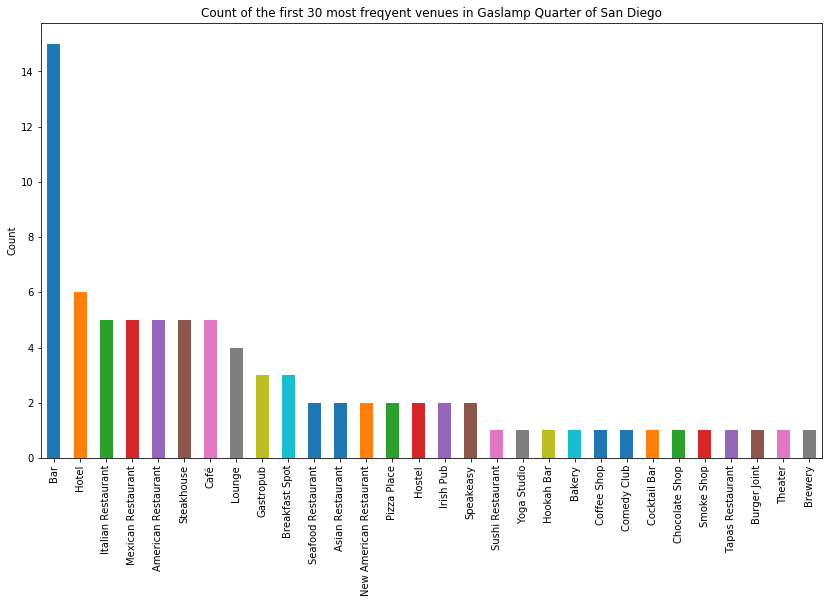

In [171]:
# bar plot of Gaslamp Quarter
df_GL = neighs_venues[neighs_venues['Neighborhood']=='Gaslamp Quarter']
name_ind_map = {x:y for x, y in zip(df_GL["Neighborhood"],df_GL["Venue Category"])}
xx    = df_GL['Venue Category'].value_counts() 
ax    = xx[:30].plot(kind='bar',figsize=(14,8), title="Count of the first 30 most freqyent venues in Gaslamp Quarter of San Diego")
#ax.set_xlabel("")
ax.set_ylabel("Count")
plt.show()

In [104]:
restaurants.drop(restaurants[restaurants['Neighborhood']=='Gaslamp Quarter'].index, inplace=True)
restaurants.reset_index(drop=True,inplace=True)
cocktail_bars.drop(cocktail_bars[cocktail_bars['Neighborhood']=='Gaslamp Quarter'].index, inplace=True)
cocktail_bars.reset_index(drop=True,inplace=True)
count_cocktail_bars.drop(count_cocktail_bars[count_cocktail_bars['Neighborhood']=='Gaslamp Quarter'].index, inplace=True)
count_cocktail_bars.reset_index(drop=True,inplace=True)

Remove also the Border neighborhood.

In [121]:
restaurants.drop(restaurants[restaurants['Neighborhood']=='Border'].index, inplace=True)
restaurants.reset_index(drop=True,inplace=True)
cocktail_bars.drop(cocktail_bars[cocktail_bars['Neighborhood']=='Border'].index, inplace=True)
cocktail_bars.reset_index(drop=True,inplace=True)
count_cocktail_bars.drop(count_cocktail_bars[count_cocktail_bars['Neighborhood']=='Border'].index, inplace=True)
count_cocktail_bars.reset_index(drop=True,inplace=True)

Remove these neighborhoods from the dataframe that will be used for the k-means as well:

In [155]:
SD_grouped.drop(SD_grouped[SD_grouped['Neighborhood']=='Border'].index, inplace=True)
SD_grouped.reset_index(drop=True,inplace=True)
SD_grouped.drop(SD_grouped[SD_grouped['Neighborhood']=='Border'].index, inplace=True)
SD_grouped.reset_index(drop=True,inplace=True)

SD_grouped_clustering = SD_grouped.drop('Neighborhood', 1)

In [162]:
neighborhoods_venues_sorted.drop(neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood']=='Border'].index, inplace=True)
neighborhoods_venues_sorted.reset_index(drop=True,inplace=True)
neighborhoods_venues_sorted.drop(neighborhoods_venues_sorted[neighborhoods_venues_sorted['Neighborhood']=='Border'].index, inplace=True)
neighborhoods_venues_sorted.reset_index(drop=True,inplace=True)

Create a dataframe with the number of cocktail bars per neighborhood, and record the lat and lon of the neigborhoods as well

In [122]:
count_cocktail_bars.head()

,Neighborhood,Count,Venue,Longitude,Latitude
0,Core,23,23,-117.159680,32.717277
1,El Cerrito,18,18,-117.162771,32.717421
2,Midway,18,18,-117.162771,32.717421
3,Little Italy,14,14,-117.168272,32.723458
4,Harborview,13,13,-117.171852,32.725750


In [123]:
# extract only the neighborhoods from the cocktail_bars dataframe (without duplicates)
neigh_cocktail_bars = pd.DataFrame()
neigh_cocktail_bars['Neighborhood'] = cocktail_bars['Neighborhood'].drop_duplicates()
for nn in neigh_cocktail_bars['Neighborhood']:
    lonB = df[df['Neighborhood'] ==  nn ]['Longitude']
    latB = df[df['Neighborhood'] ==  nn ]['Latitude']
    count_cocktail_bars.loc[count_cocktail_bars['Neighborhood']==nn, 'Longitude'] = float(lonB)
    count_cocktail_bars.loc[count_cocktail_bars['Neighborhood']==nn, 'Latitude']  = float(latB)

count_cocktail_bars.head()

,Neighborhood,Count,Venue,Longitude,Latitude
0,Core,23,23,-117.159680,32.717277
1,El Cerrito,18,18,-117.162771,32.717421
2,Midway,18,18,-117.162771,32.717421
3,Little Italy,14,14,-117.168272,32.723458
4,Harborview,13,13,-117.171852,32.725750


In [124]:
map_cocktail_bars = folium.Map(location=[latitudeSD, longitudeSD], zoom_start=11)
folium.Marker([latitudeSD, longitudeSD], popup='San Diego').add_to(map_cocktail_bars)
folium.TileLayer('cartodbpositron').add_to(map_cocktail_bars)

for lat, lon, poi, bar in zip(cocktail_bars['Venue Latitude'], cocktail_bars['Venue Longitude'], cocktail_bars['Neighborhood'], cocktail_bars['Venue Category']):
    #label = '{}, {}'.format(poi,bar)
    #label = folium.Popup(label, parse_html=True)
    label = folium.Popup(str(poi) + ', ' + str(bar), parse_html=True)
    folium.CircleMarker([lat, lon], radius=3, 
                        popup=label, 
                        color='magenta', fill=True, fill_color='magenta', fill_opacity=1,parse_html=False).add_to(map_cocktail_bars)

for lat, lon, poi, cc in zip(count_cocktail_bars['Latitude'], count_cocktail_bars['Longitude'], count_cocktail_bars['Neighborhood'], count_cocktail_bars['Count']):
    folium.CircleMarker([lat, lon], radius=50, color='#0000ff00', fill=True, fill_color='blue', fill_opacity=cc/count_cocktail_bars['Count'].sum()).add_to(map_cocktail_bars)

    
map_cocktail_bars

In [125]:
from folium.plugins import HeatMap

bars_latlons = [np.asarray(cocktail_bars['Venue Longitude']), np.asarray(cocktail_bars['Venue Latitude'])]

heat_df      = pd.DataFrame()
heat_df['Longitude'] = cocktail_bars['Venue Longitude']
heat_df['Latitude']  = cocktail_bars['Venue Latitude']
heat_data    = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]

map_cocktail_bars = folium.Map(location=[latitudeSD, longitudeSD], zoom_start=11)
folium.Marker([latitudeSD, longitudeSD], popup='San Diego').add_to(map_cocktail_bars)
folium.TileLayer('cartodbpositron').add_to(map_cocktail_bars)
HeatMap(heat_data).add_to(map_cocktail_bars)

for lat, lon, poi, bar in zip(cocktail_bars['Venue Latitude'], cocktail_bars['Venue Longitude'], cocktail_bars['Neighborhood'], cocktail_bars['Venue Category']):
    label = folium.Popup(str(poi) + ', ' + str(bar), parse_html=True)
    #folium.Marker([lat, lon], popup=label,icon=folium.Icon(color='red',icon='glass', prefix='fa')).add_to(map_cocktail_bars)
    folium.CircleMarker([lat, lon], radius=3, color='magenta',fill=True, fill_color='magenta', fill_opacity=1).add_to(map_cocktail_bars)

for lat, lon, poi, cc in zip(count_cocktail_bars['Latitude'], count_cocktail_bars['Longitude'], count_cocktail_bars['Neighborhood'], count_cocktail_bars['Count']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.Marker([lat, lon], popup=label,icon=folium.Icon(color='red',icon='glass', prefix='fa')).add_to(map_cocktail_bars)
    folium.CircleMarker([lat, lon], radius=50, color='blue', fill=True, fill_color='cyan', fill_opacity=cc/count_cocktail_bars['Count'].sum()).add_to(map_cocktail_bars)


map_cocktail_bars

## 4. Cluster the neighborhoods in _5_ groups, using the k-Means algorithm

### 4.1 Find the clusters

In [160]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels'] = 0 

In [158]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SD_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 0, 0, 0, 0, 1, 3, 3], dtype=int32)

In [163]:
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_ 

In [164]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Balboa Park,Zoo Exhibit,Garden,Art Museum,Theater,History Museum,Performing Arts Venue,Gift Shop,Café,Exhibit,Theme Park Ride / Attraction,0
1,Bankers Hill,Spa,American Restaurant,Coffee Shop,Restaurant,Sports Club,Gastropub,Liquor Store,Lounge,Taco Place,Sushi Restaurant,1
2,Barrio Logan,Fast Food Restaurant,Coffee Shop,Mexican Restaurant,Taco Place,Convenience Store,Shopping Mall,Boat or Ferry,Gift Shop,Tailor Shop,Art Gallery,0
3,Bay Ho,Bus Stop,Gym Pool,Sandwich Place,Seafood Restaurant,Market,Salad Place,Farmers Market,Baseball Stadium,Greek Restaurant,Coffee Shop,0
4,Carmel Mountain Ranch,Fast Food Restaurant,Mexican Restaurant,Coffee Shop,Grocery Store,Pizza Place,Juice Bar,BBQ Joint,Clothing Store,Greek Restaurant,Chinese Restaurant,0


### 4.2 Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [168]:
SD_merged  = df[df['Neighborhood'].isin(df2.loc[df2['count']>=20,'Neighborhood'])]

# merge toronto_grouped with borough to add latitude/longitude for each neighborhood
SD_merged  = SD_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

SD_merged.drop(SD_merged[SD_merged['Neighborhood']=='Border'].index, inplace=True)
SD_merged.reset_index(drop=True,inplace=True)
SD_merged.drop(SD_merged[SD_merged['Neighborhood']=='Border'].index, inplace=True)
SD_merged.reset_index(drop=True,inplace=True)


SD_merged['Cluster Labels'] = SD_merged['Cluster Labels'].astype(int)
SD_merged.head()

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Balboa Park,32.731357,-117.146527,Zoo Exhibit,Garden,Art Museum,Theater,History Museum,Performing Arts Venue,Gift Shop,Café,Exhibit,Theme Park Ride / Attraction,0
1,Bankers Hill,32.728293,-117.162105,Spa,American Restaurant,Coffee Shop,Restaurant,Sports Club,Gastropub,Liquor Store,Lounge,Taco Place,Sushi Restaurant,1
2,Barrio Logan,32.693886,-117.138007,Fast Food Restaurant,Coffee Shop,Mexican Restaurant,Taco Place,Convenience Store,Shopping Mall,Boat or Ferry,Gift Shop,Tailor Shop,Art Gallery,0
3,Bay Ho,32.879353,-117.231100,Bus Stop,Gym Pool,Sandwich Place,Seafood Restaurant,Market,Salad Place,Farmers Market,Baseball Stadium,Greek Restaurant,Coffee Shop,0
4,Carmel Mountain Ranch,32.980393,-117.078364,Fast Food Restaurant,Mexican Restaurant,Coffee Shop,Grocery Store,Pizza Place,Juice Bar,BBQ Joint,Clothing Store,Greek Restaurant,Chinese Restaurant,0


## 5. Visualize the results using _Folium_ to create a map

In [169]:
# create map
map_clusters = folium.Map(location=[latitudeSD, longitudeSD], zoom_start=11)

# set color scheme for the clusters
x  = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_clusters = folium.Map(location=[latitudeSD, longitudeSD], zoom_start=11)
folium.Marker([latitudeSD, longitudeSD], popup='San Diego').add_to(map_clusters)
folium.TileLayer('cartodbpositron').add_to(map_clusters)
HeatMap(heat_data).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SD_merged['Latitude'], SD_merged['Longitude'], SD_merged['Neighborhood'], SD_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)
       
map_clusters

## !!! THE MAP DOES NOT SHOW ON GITHUB.. To visualize the whole notebook with the folium map, Please, copy the link of this notebook and paste it on https://nbviewer.jupyter.org/ !!! Thank you!!

### Look at the first clusters

Create a function to count all the venues by cluster

In [285]:
def count_venue_clusters(clus):
    df_count = pd.DataFrame()
    df_count['Venue'] = ""
    df_clst = SD_merged.loc[SD_merged['Cluster Labels'] == clus]
    for col in df_clst.columns[3:-1]:
        for vv in df_clst[col]:
            df_count = df_count.append({'Venue': vv}, ignore_index=True)
    return df_count

#### Cluster 0

In [283]:
# selec the results for the cluster 1
SD_merged.loc[SD_merged['Cluster Labels'] == 0, SD_merged.columns[[0] + list(range(3, SD_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Balboa Park,Zoo Exhibit,Garden,Art Museum,Theater,History Museum,Performing Arts Venue,Gift Shop,Café,Exhibit,Theme Park Ride / Attraction,0
2,Barrio Logan,Fast Food Restaurant,Coffee Shop,Mexican Restaurant,Taco Place,Convenience Store,Shopping Mall,Boat or Ferry,Gift Shop,Tailor Shop,Art Gallery,0
3,Bay Ho,Bus Stop,Gym Pool,Sandwich Place,Seafood Restaurant,Market,Salad Place,Farmers Market,Baseball Stadium,Greek Restaurant,Coffee Shop,0
4,Carmel Mountain Ranch,Fast Food Restaurant,Mexican Restaurant,Coffee Shop,Grocery Store,Pizza Place,Juice Bar,BBQ Joint,Clothing Store,Greek Restaurant,Chinese Restaurant,0
5,City Heights,Chinese Restaurant,Pizza Place,Mexican Restaurant,Grocery Store,Sandwich Place,Asian Restaurant,Optical Shop,Shoe Store,Coffee Shop,Snack Place,0
6,Clairemont,Mexican Restaurant,Bakery,Coffee Shop,Burger Joint,Pizza Place,Supplement Shop,Grocery Store,Mediterranean Restaurant,Bookstore,Department Store,0
17,Hillcrest,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Italian Restaurant,Chinese Restaurant,Pharmacy,Restaurant,Sandwich Place,Gastropub,0
21,Midtown,Mexican Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Italian Restaurant,Restaurant,Gay Bar,Café,Greek Restaurant,Bakery,0
22,Mira Mesa,Dessert Shop,Fast Food Restaurant,Seafood Restaurant,Grocery Store,Pet Store,Park,Coffee Shop,Photography Studio,Department Store,Bank,0
24,Mission Valley,Coffee Shop,Cosmetics Shop,Burger Joint,Bookstore,Pizza Place,Seafood Restaurant,Grocery Store,Gym,Bakery,Department Store,0


_It looks like Cluster 0 is popuar for restaurants, hotels, breweries.. lots of activities_

#### Cluster 1

In [295]:
SD_merged.loc[SD_merged['Cluster Labels'] == 1, SD_merged.columns[[0] + list(range(4, SD_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,Bankers Hill,American Restaurant,Coffee Shop,Restaurant,Sports Club,Gastropub,Liquor Store,Lounge,Taco Place,Sushi Restaurant,1
7,Columbia,Italian Restaurant,New American Restaurant,Coffee Shop,Café,Sushi Restaurant,Mexican Restaurant,Sandwich Place,Gym,Convenience Store,1
12,Little Italy,Hotel,American Restaurant,Coffee Shop,Wine Bar,Brewery,Pizza Place,ATM,Ice Cream Shop,Japanese Restaurant,1
14,Gateway,Cosmetics Shop,Food Truck,Clothing Store,Gym,Sandwich Place,Furniture / Home Store,New American Restaurant,Candy Store,Salad Place,1
16,Harborview,Coffee Shop,American Restaurant,Rental Car Location,Hotel,Wine Bar,Brewery,Pizza Place,Japanese Restaurant,Sandwich Place,1
19,Village of La Jolla,Italian Restaurant,Juice Bar,Café,Gym,Sandwich Place,Breakfast Spot,Sporting Goods Shop,Bookstore,Spa,1
23,Mission Beach,Board Shop,Greek Restaurant,Deli / Bodega,Recreation Center,Pharmacy,Restaurant,Park,Coffee Shop,Chinese Restaurant,1
31,Pacific Beach,Pharmacy,Sushi Restaurant,Italian Restaurant,Dive Bar,Coffee Shop,Ice Cream Shop,Mexican Restaurant,Grocery Store,Yoga Studio,1
36,Shelter Island,Harbor / Marina,Boat or Ferry,Bar,Hotel Pool,American Restaurant,Island,Hotel,Fishing Spot,Memorial Site,1
38,South Park,Italian Restaurant,Breakfast Spot,Brewery,Taco Place,Bike Shop,Big Box Store,Gift Shop,Coffee Shop,Grocery Store,1


#### Cluster 2

In [296]:
SD_merged.loc[SD_merged['Cluster Labels'] == 2, SD_merged.columns[[0] + list(range(4, SD_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
20,Memorial,Seafood Restaurant,Pier,Harbor / Marina,Deli / Bodega,Park,Museum,Pizza Place,Café,Sushi Restaurant,2


_This cluster has a little bit of everything, from restaurant and cafes, to stores, gyms and movie theaters._

#### Cluster 3

In [297]:
SD_merged.loc[SD_merged['Cluster Labels'] == 3, SD_merged.columns[[0] + list(range(4, SD_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
8,Core,Hotel,Coffee Shop,Italian Restaurant,Bar,Café,Lingerie Store,American Restaurant,Seafood Restaurant,Sushi Restaurant,3
9,Cortez Hill,Park,Mexican Restaurant,Café,Pizza Place,Hotel,Taco Place,Concert Hall,Convenience Store,Donut Shop,3
10,East Village,Gastropub,Mexican Restaurant,Ramen Restaurant,Bar,Bagel Shop,Fast Food Restaurant,Sporting Goods Shop,Breakfast Spot,Brewery,3
11,Gaslamp Quarter,Hotel,Steakhouse,American Restaurant,Italian Restaurant,Café,Mexican Restaurant,Lounge,Breakfast Spot,Gastropub,3
13,El Cerrito,Coffee Shop,Mexican Restaurant,American Restaurant,New American Restaurant,Lingerie Store,Italian Restaurant,Seafood Restaurant,Sushi Restaurant,Theater,3
15,Golden Hill,Mexican Restaurant,Pizza Place,Grocery Store,Spa,Steakhouse,Taco Place,Mediterranean Restaurant,Market,Thai Restaurant,3
18,Kensington,Park,Movie Theater,Spa,Café,French Restaurant,Mexican Restaurant,Shipping Store,Sculpture Garden,Organic Grocery,3
25,Morena,Sandwich Place,Gym,Brewery,Mexican Restaurant,Convenience Store,Donut Shop,ATM,Deli / Bodega,Bridal Shop,3
27,Normal Heights,Liquor Store,Taco Place,ATM,Bar,Italian Restaurant,Hookah Bar,Grocery Store,Mexican Restaurant,Fried Chicken Joint,3
28,North Park,Mexican Restaurant,Pizza Place,Brewery,Sushi Restaurant,Bar,Breakfast Spot,American Restaurant,Ice Cream Shop,Thai Restaurant,3


#### Cluster 4

In [298]:
SD_merged.loc[SD_merged['Cluster Labels'] == 4, SD_merged.columns[[0] + list(range(4, SD_merged.shape[1]))]]

,Neighborhood,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
34,San Ysidro,Motel,Insurance Office,Financial or Legal Service,Liquor Store,Art Gallery,Marijuana Dispensary,Pet Store,Gas Station,Convenience Store,4


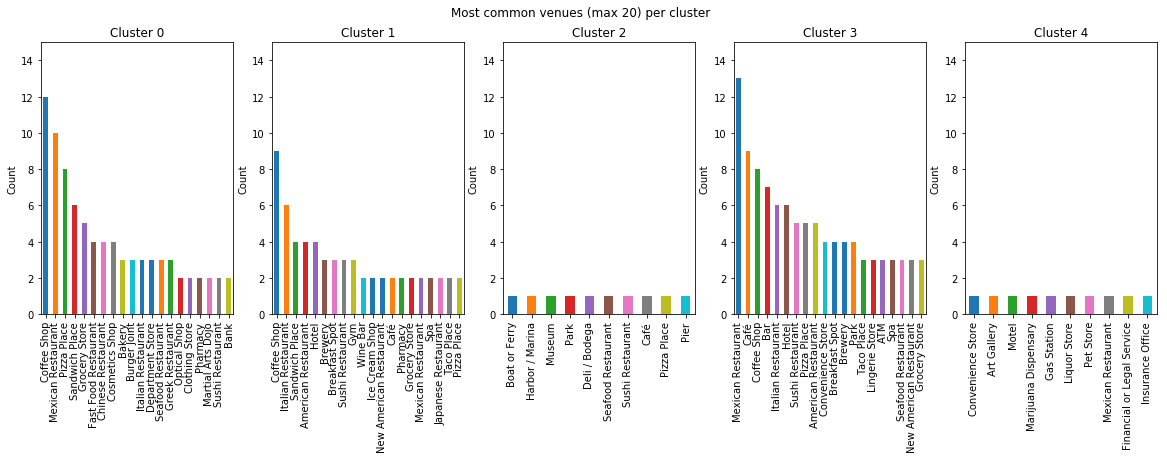

In [310]:
# bar plot of cluster 0
fig   = plt.figure(figsize=(20,5))
for clus in range(kclusters):
    df_count = count_venue_clusters(clus)
    ax    = fig.add_subplot(1,5,clus+1)
    xx    = df_count['Venue'].value_counts() 
    ax    = xx[:20].plot(kind='bar', title="Cluster %i" %clus)
    #ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.set_ylim(0,15)
plt.suptitle('Most common venues (max 20) per cluster')
plt.show()